In [ ]:
import torch
import pandas as pd
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import random
import time

In [ ]:
class airfoildata(Dataset):
  def __init__(self,dir,split='train'):
    super(airfoildata, self).__init__()
    self.dir=dir
    self.get_pairs()
    self.get_samples()
    self.split()
    if split=='train':
      self.data=self.train
      self.pairs=None
      self.sample=None
      self.train=None
      self.test=None
    elif split=='test':
      self.data=self.test
      self.pairs=None
      self.sample=None
      self.train=None
      self.test=None
    else:
      self.pairs=None
      self.sample=None
      self.train=None
      self.test=None
      print('error')

  def get_img(self,file):
    im=np.asarray(Image.open(file))
    return(im.reshape((1,)+im.shape))

  def get_df(self,file):
    f=open(file)
    _=np.asarray(f.read().split('\n')[10:])
    _=list(np.core.defchararray.split(_,","))
    return(pd.DataFrame(_[1:-1],columns=_[0]))
  
  def get_pairs(self):
    imgs=[]
    csf=[]
    for i in os.listdir(dir):
      if i[-3:]=="gif":
        imgs.append(i)
      elif i[-3:]=="csv":
        csf.append(i)
      else:
        pass
    self.pairs=[[i,'xf-'+i[5:-4]+'-il-1000000.csv'] for i in imgs if 'xf-'+i[5:-4]+'-il-1000000.csv' in csf]

  def get_samples(self):
    data=[[self.get_img(self.dir+x), self.get_df(self.dir+y)] for x,y in self.pairs]
    self.samples=[[x,float(i),float(j)] for x,y in data for i,j in y[['Alpha','Cl']].values ]

  def split(self):
    random.shuffle(self.samples)
    self.train=self.samples[:int(0.9*len(self.samples))]
    self.test=self.samples[int(0.9*len(self.samples)):]

  def __len__(self):
    return(len(self.data))
  
  def __getitem__(self,idx):
    return(self.data[idx])

In [ ]:
class net(torch.nn.Module):
  def __init__(self):
     super(net, self).__init__()
     self.cnn=torch.nn.Sequential(
              torch.nn.Conv2d(1, 4, 7, 2),
              torch.nn.BatchNorm2d(4),
              torch.nn.MaxPool2d(2,2),
              torch.nn.Conv2d(4, 16, 5, 2),
              torch.nn.BatchNorm2d(16),
              torch.nn.MaxPool2d(2,2),
              torch.nn.Conv2d(16, 64, 3, 2),
              torch.nn.BatchNorm2d(64),
              torch.nn.MaxPool2d(2,2),
              torch.nn.ReLU(inplace=True)
     )

     self.dense1=torch.nn.Sequential(
                 torch.nn.Linear(14976, 5000),
                 torch.nn.GELU(),
                 torch.nn.Linear(5000, 500),
                 torch.nn.Dropout(p=0.75, inplace=True),
                 torch.nn.Tanh()
                 
     )

     self.dense2=torch.nn.Sequential(   
                 torch.nn.Linear(501, 50),
                 torch.nn.Tanh(),               
                 torch.nn.Linear(50, 10),
                 torch.nn.Tanh(),
                 torch.nn.Linear(10, 5),
                 torch.nn.Tanh(),
                #  torch.nn.Dropout(p=0.75, inplace=True),
                 torch.nn.Linear(5, 1),
                 torch.nn.Tanh()
     )
     
  def forward(self,img,alpha):
    x1=self.cnn(img)
    x1=x1.flatten()
    x1=self.dense1(x1)
    x=torch.cat((x1,alpha))
    y=self.dense2(x)
    return(y*10)

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [ ]:
dir="/content/drive/MyDrive/Prediction Check 2/"
epoch=5
def build_model():
  model=net()
  model=model.cuda()
  return(model)

def build_param(model):
  optimizer=torch.optim.Adam(model.parameters(), lr=0.0025)
  loss=torch.nn.MSELoss()
  loss=loss.cuda()
  return(loss,optimizer)

def get_data(dir,split):
  dataset=airfoildata(dir,split)
  data=DataLoader(dataset, batch_size=1)
  return(data)  

def train(model, dir, epoch):
  loss,optim=build_param(model)
  train_data=get_data(dir,'train')
  total_losses=[]
  for i in range(epoch):
    st=time.time()
    model.train()
    losses=[]
    for num,(img, alpha, y) in enumerate(train_data):
      model.zero_grad()
      pred=model(torch.tensor(img,dtype=torch.float).cuda(), torch.tensor(alpha,dtype=torch.float).cuda())
      loss_train=loss(pred,torch.tensor(y,dtype=torch.float).cuda())
      loss_train.backward()
      optim.step()
      if num%100==0:
        losses.append(loss_train.item())
    total_losses.append(sum(losses)/num)
    print("epoch:",i,", loss:",sum(losses)/num,", time:",time.time()-st)
  return(model,total_losses)

In [ ]:
model=build_model()
model,total_losses=train(model, dir, 50)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


epoch: 0 , loss: 0.00307887817405531 , time: 187.2008879184723
epoch: 1 , loss: 0.0009777415981597206 , time: 187.50988864898682
epoch: 2 , loss: 0.0006898110890767675 , time: 187.79603552818298
epoch: 3 , loss: 0.0006316857330637264 , time: 187.7053554058075
epoch: 4 , loss: 0.0005838964700600214 , time: 187.5510528087616
epoch: 5 , loss: 0.000544882263874242 , time: 187.59405279159546
epoch: 6 , loss: 0.0006218459478478193 , time: 187.58858227729797
epoch: 7 , loss: 0.0007287977852508187 , time: 187.6034426689148
epoch: 8 , loss: 0.000615849194439443 , time: 187.89815211296082
epoch: 9 , loss: 0.0007107772861317279 , time: 187.82286524772644
epoch: 10 , loss: 0.0006077451798885577 , time: 187.6441135406494
epoch: 11 , loss: 0.0007709004119444752 , time: 187.67973256111145
epoch: 12 , loss: 0.0006529334977647334 , time: 187.89073610305786
epoch: 13 , loss: 0.0007812152660863891 , time: 188.20178651809692
epoch: 14 , loss: 0.0006051614583189387 , time: 188.56480145454407
epoch: 15 , lo

In [ ]:
dataset=airfoildata(dir,'train')
img=dataset.get_img("/content/drive/MyDrive/Prediction Check 2/Inkedn12.gif")
df=dataset.get_df("/content/drive/MyDrive/Prediction Check 2/xf-n12-il-1000000.csv")
data=[[img,df]]
samples=[[x,float(i),float(j)] for x,y in data for i,j in y[['Alpha','Cl']].values ]
r=np.arange(-16.5,18.25,0.25)

In [ ]:
pred=[]
for i,x,y in samples:
# im=samples0[0][0]
# for i in r:
  pred.append([x, model(torch.tensor([i],dtype=torch.float).cuda(), torch.tensor([x],dtype=torch.float).cuda()).cpu().detach(),y])

In [ ]:
pred

[[-16.5, tensor([-0.9895]), -1.026],
 [-16.25, tensor([-0.9895]), -1.0806],
 [-16.0, tensor([-0.9851]), -1.1177],
 [-15.75, tensor([-0.9895]), -1.1416],
 [-15.5, tensor([-0.9895]), -1.1567],
 [-15.25, tensor([-0.9894]), -1.169],
 [-15.0, tensor([-0.9894]), -1.1791],
 [-14.75, tensor([-0.9891]), -1.1788],
 [-14.5, tensor([-0.9895]), -1.1856],
 [-14.25, tensor([-0.9895]), -1.1986],
 [-14.0, tensor([-0.9892]), -1.2082],
 [-13.75, tensor([-0.9892]), -1.2063],
 [-13.5, tensor([-0.8685]), -1.1966],
 [-13.25, tensor([-0.7760]), -1.1867],
 [-13.0, tensor([-0.8884]), -1.1786],
 [-12.75, tensor([-0.9893]), -1.1715],
 [-12.5, tensor([-0.9892]), -1.1623],
 [-12.25, tensor([-0.9715]), -1.1538],
 [-12.0, tensor([-0.8302]), -1.1503],
 [-11.75, tensor([-0.7418]), -1.1389],
 [-11.5, tensor([-0.6323]), -1.1274],
 [-11.25, tensor([-0.5970]), -1.1138],
 [-11.0, tensor([-0.5900]), -1.1079],
 [-10.75, tensor([-0.7875]), -1.0929],
 [-10.5, tensor([-0.6090]), -1.076],
 [-10.25, tensor([-0.6532]), -1.0584],
 [

In [ ]:
p2=np.asarray(pred)

In [ ]:
p=np.asarray(pred)
s=np.asarray(samples0)

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [ ]:
import matplotlib.pyplot as plt

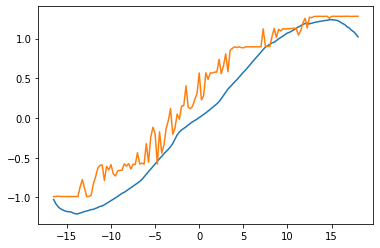

In [ ]:
plt.plot(p2[:,0],p2[:,2],p2[:,0],p2[:,1])